In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/Users/hirofumi48/162348.github.io/posts/2025/PDMP"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


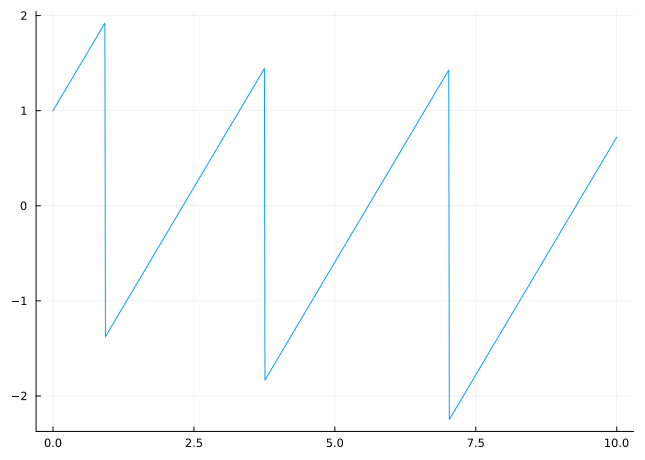

In [2]:
using Random, Distributions, Plots

function SimulateSkeleton(x₀; T::Float64=20.0, seed::Int=2025)

  rng = MersenneTwister(seed)
  τ = () -> rand(rng, Rayleigh(1.0))

  if x₀ <= 0
    tₑ = -x₀ + τ()
  else
    tₑ = -x₀ + sqrt(x₀ - 2log(1-rand(rng)))
  end

  skeletons = [0.0, tₑ]
  positions = [x₀]

  while tₑ < T
    τ₁, τ₂ = τ(), τ()
    tₑ += τ₁ + τ₂
    push!(skeletons, tₑ)
    push!(positions, -τ₁)
  end

  return skeletons[1:end-1], positions
end

function DiscretizeSkeleton(skeletons::Vector{Float64}, positions::Vector{Float64}, dt::Float64=0.01, T::Float64=10.0)

  tᵢ = 0.0:dt:T
  i = searchsortedfirst.(Ref(skeletons), tᵢ) .- 1
  i[1] = 1
  flow = (x,t) -> x + t
  locate = (j,t) -> flow(positions[j], t - skeletons[j])
  samples = [locate(j, t) for (j, t) in zip(i, tᵢ)]

  return tᵢ, samples
end

function sample(x₀::Float64; seed::Int=2025)

  skeletons, positions = SimulateSkeleton(x₀, seed=seed)
  tᵢ, samples = DiscretizeSkeleton(skeletons, positions)
end

plot(sample(1.0, seed=2024), legend=false)

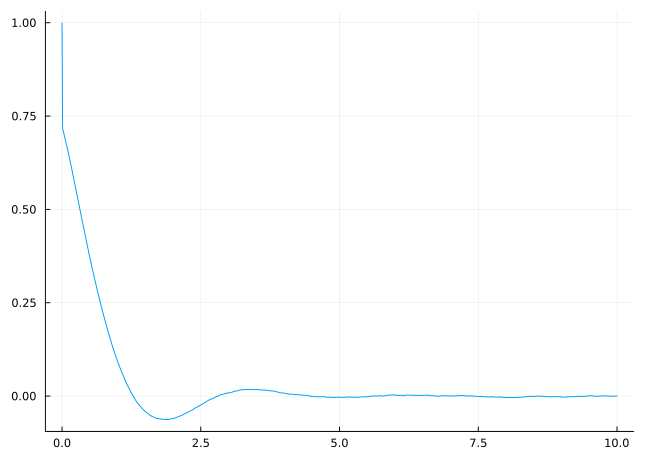

In [3]:
function calc_covariance(N::Int=502500)
  t, x = sample(0.0, seed=1)
  ρₙ = Matrix{Float64}(undef, N, length(t))

  for seed in 1:N
    x₀ = randn()
    t, x = sample(x₀, seed=seed)
    ρₙ[seed, :] = x₀ * x
  end

  return t, mean(ρₙ, dims=1)[:]
end

plot(calc_covariance(), legend=false)

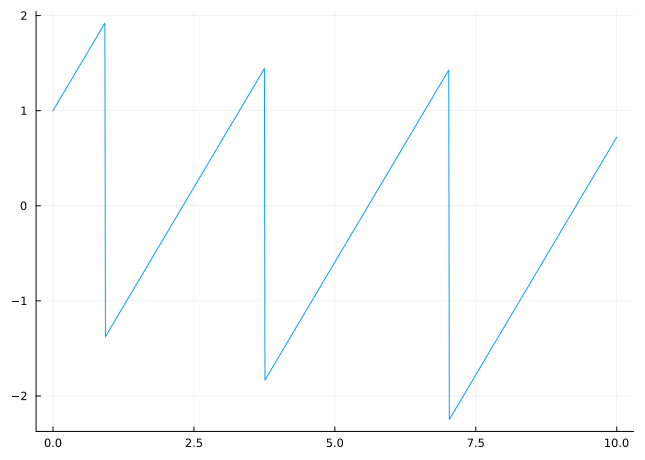

In [4]:
function SimulateBPSSkeleton(x₀; T::Float64=20.0, seed::Int=2025)

  rng = MersenneTwister(seed)
  τ = () -> rand(rng, Rayleigh(1.0))

  if x₀ <= 0
    tₑ = -x₀ + τ()
  else
    tₑ = -x₀ + sqrt(x₀ - 2log(1-rand(rng)))
  end

  skeletons = [0.0, tₑ]
  positions = [x₀]

  while tₑ < T
    τ₁, τ₂ = τ(), τ()
    tₑ += τ₁ + τ₂
    push!(skeletons, tₑ)
    push!(positions, -τ₁)
  end

  return skeletons[1:end-1], positions
end

function sampleBPS(x₀::Float64; seed::Int=2025)

  skeletons, positions = SimulateBPSSkeleton(x₀, seed=seed)
  tᵢ, samples = DiscretizeSkeleton(skeletons, positions)
end

plot(sampleBPS(1.0, seed=2024), legend=false)

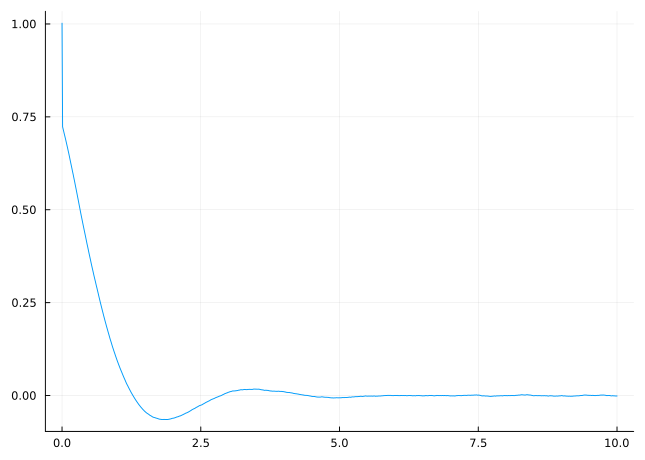

In [5]:
function calc_BPS_Covariance(N::Int=502500)
  t, x = sampleBPS(0.0, seed=1)
  ρₙ = Matrix{Float64}(undef, N, length(t))

  for seed in 1:N
    x₀ = randn()
    t, x = sampleBPS(x₀, seed=seed)
    ρₙ[seed, :] = x₀ * x
  end

  return t, mean(ρₙ, dims=1)[:]
end

plot(calc_BPS_Covariance(), legend=false)